## Implementation of the paper "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps" by Simonyan et.al. 

While implementing this paper, I also implemented some pretraining concepts in tensorflow where I pretrained a MobileNet V2 architecture with the dogs vs cats dataset as listed in tensorflow tutorials. The concepts for visualization in the paper are then applied to the pretrained model. The visualizations would be much better if applied directly on the original image net label classes.


## Loading a pre-built tensorflow dataset


In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

In [0]:
# load the cats vs dogs dataset
import tensorflow_datasets as tfds

SPLIT_WEIGHTS = (8, 1, 1)
split = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(train, val, test), metadata = tfds.load('cats_vs_dogs', split=list(split), with_info=True, as_supervised=True)

In [0]:
# A utility method to display a batch of images
def display_images(image_batch):
    batch_size = image_batch.shape[0]
    print(batch_size)
    grid_size = math.ceil(math.sqrt(batch_size))
    print(grid_size)
    
    fig, axis = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    counter = 0
    for i in range(grid_size):
        for j in range(grid_size):
            if counter >= batch_size:
                break
            axis[i, j].imshow(image_batch[counter, :])
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            counter = counter + 1
    plt.show()

In [0]:
# Method to resize and scale the images between -1 to 1
resize_shape = 160

def formatter(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5
#     resize the image
    image = tf.image.resize(image, (resize_shape, resize_shape))
    return image, label

In [0]:
# Apply resizing and batch the dataset
train_dataset = train.map(formatter).batch(32)
val_dataset = val.map(formatter).batch(32)
test_dataset = test.map(formatter).batch(32)

32
6


W0501 16:26:08.258892 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.262845 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.265631 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.271094 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.275261 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.278912 139706257147776 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 16:26:08.282468 139706

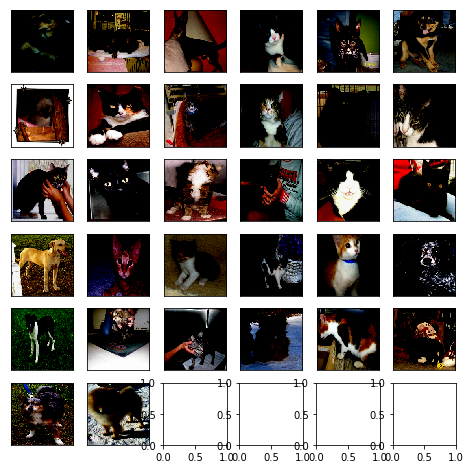

In [0]:
# Visualize a sample batcn for sanity checks
sample_batch = next(iter(train_dataset))
display_images(sample_batch[0].numpy())

## Pretraining Mobile Net with our dataset

In [0]:
# Create a custom model built on top of the MobileNetV2 model
class PretrainedModel(tf.keras.Model):
    def __init__(self, input_shape):
        super(PretrainedModel, self).__init__()
#         Load the pretrained MobileNet model and make it non trainable
        self.mobile_net = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
        self.mobile_net.trainable = True
        
        for layer in self.mobile_net.layers[:100]:
            layer.trainable =  False
        
        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        x = self.mobile_net(inputs)
        x = self.global_avg_pooling(x)
        prediction_logit = self.dense1(x)
        return prediction_logit

In [0]:
img_shape = (resize_shape, resize_shape, 3)
sample_img_batch = sample_batch[0]
sample_label_batch = sample_batch[1]

model = PretrainedModel(img_shape)
sample_predictions = model(sample_img_batch)

In [0]:
# Define a single gradient step
def compute_gradients(model, batch, optimizer):
    train_data = batch[0]
    batch_size = train_data.shape[0]
    correct_labels = tf.reshape(batch[1], (batch_size, 1))
    with tf.GradientTape() as grad:
        loss = tf.losses.sigmoid_cross_entropy(correct_labels, model(train_data))
    model_gradients = grad.gradient(loss, model.trainable_variables)
    
#     apply the gradients via the optimizer
    optimizer.apply_gradients(zip(model_gradients, model.trainable_variables))
    return model_gradients, loss

Instructions for updating:
Use tf.cast instead.


W0501 16:26:55.996713 139706257147776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch #1, Loss: 0.6732114553451538
Epoch #1, Loss: 0.03687535971403122
Epoch #1, Loss: 0.07429154217243195
Epoch #1, Loss: 0.040968168526887894
Epoch #1, Loss: 0.04234135150909424
Epoch #1, Loss: 0.05349339544773102
Epoch #2, Loss: 0.08800773322582245
Epoch #2, Loss: 0.0481971800327301
Epoch #2, Loss: 0.11416942626237869
Epoch #2, Loss: 0.002511114813387394
Epoch #2, Loss: 0.18475399911403656
Epoch #2, Loss: 0.05537400022149086
Epoch #3, Loss: 0.03468229994177818
Epoch #3, Loss: 0.021157650277018547
Epoch #3, Loss: 0.03404482454061508
Epoch #3, Loss: 0.02202601544559002
Epoch #3, Loss: 0.0038025067187845707
Epoch #3, Loss: 0.022304454818367958
Epoch #4, Loss: 0.0017537365201860666
Epoch #4, Loss: 0.07638043165206909
Epoch #4, Loss: 0.010345936752855778
Epoch #4, Loss: 0.0007321524899452925
Epoch #4, Loss: 0.00044649443589150906
Epoch #4, Loss: 0.023622149601578712
Epoch #5, Loss: 0.13320571184158325
Epoch #5, Loss: 0.0031661486718803644
Epoch #5, Loss: 0.04002666473388672
Epoch #5, Los

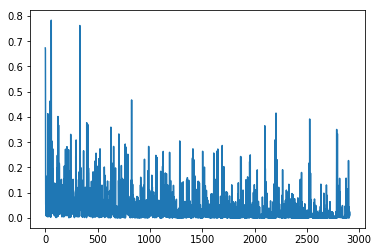

In [0]:
# Define the optmizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

model = PretrainedModel(img_shape)
num_training_steps = 5
loss_profile = []
epoch_range = range(num_training_steps)

for epoch_idx in epoch_range:
    counter = 0
    for train_batch in train_dataset:
        _, loss = compute_gradients(model, train_batch, optimizer)
        loss_profile.append(loss)
        if counter % 100 == 0:
            print(f'Epoch #{epoch_idx + 1}, Loss: {loss}')
        counter = counter + 1

plt.plot(loss_profile)

In [0]:
#TODO: Compute the predictions over the test data
# Assuming that the model is trained well over the data

## Score Analysis for the model

The main motivation behind score analysis is to randomly initialize an image and compute its score by forward passing it through the neural net. The objective is then to maximize a class specific score and backprop over the image picels to generate an image visualized by the net when seeing that score.

The image generated in this case is not particularly interpretable(maybe due to fine tuning) but the score is maximized and converges to a high value for this image.

TODO: Add the mean of the training data to the generated image

In [0]:
def compute_image_grad(model, img, reg_param=1.0):
    with tf.GradientTape() as image_grad:
        image_grad.watch(img)
        loss = -model(img) + reg_param * tf.pow(tf.norm(img), 2)
    image_gradient = image_grad.gradient(loss, img)
    return image_gradient, loss

Epoch: 4900 Loss: [[-31.199986]]


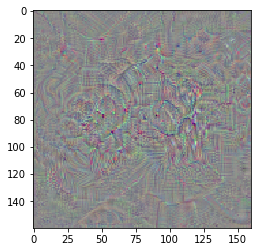

In [0]:
from IPython import display

# Initialize a random image
I = tf.random_normal((1, resize_shape, resize_shape, 3))
reg_param = 0.01
learning_rate = 0.5

loss_profile = []
num_steps = 5000
for epoch_idx in range(num_steps):
    grad, loss = compute_image_grad(model, I, reg_param=reg_param)
#     Update the image
    I = I - learning_rate * grad
    if epoch_idx % 100 == 0:
        display.clear_output(wait=True)
#         Visualize the image after every 100th epoch
        print(f'Epoch: {epoch_idx} Loss: {loss}')
        I_np = I.numpy().reshape(img_shape)
#         Scaling operation
        I_np = (I_np - np.min(I_np))/(np.max(I_np) - np.min(I_np))
        plt.imshow(I_np)
        plt.show()

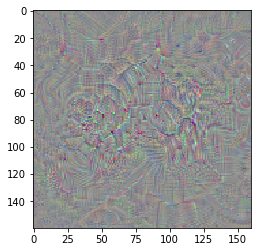

In [0]:
# Rescale the image between 0 to 1
I_np = I.numpy().reshape(img_shape)
I_np = (I_np - np.min(I_np))/(np.max(I_np) - np.min(I_np))
plt.imshow(I_np)

## Salience map extraction

Saliency maps visualize the contribution of each of the pixels in an image to the final score computed by the fine tuned network. Refer to Section 3 of the paper where the authors justify the importance of these maps and use them for object localization and segmentation by using the saliency maps as initialization maps for GraphCut segmentation.

Refer to Sec4 for an explanation of how the computation of saliency maps correspond to Deconvolution layers to visualize the neural net feature maps.

Here, the saliency map extraction is done on a batch of cross validation samples of cats and dogs and give meaningful results.

32
6


W0501 06:15:57.145312 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.147840 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.151498 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.154960 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.157371 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.160312 140382229473152 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0501 06:15:57.163096 140382

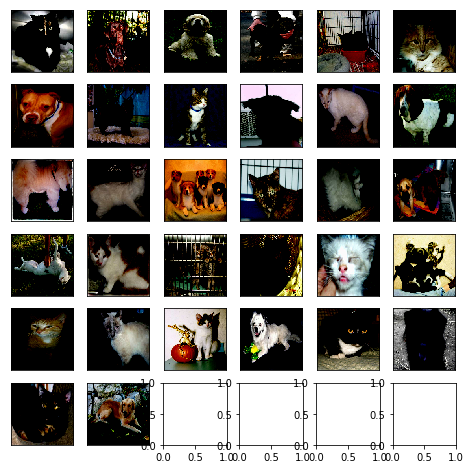

In [0]:
val_batch = next(iter(val_dataset))
# Visualize the validation batch
display_images(val_batch[0].numpy())

In [0]:
val_image = tf.reshape(val_batch[0][22], (1, resize_shape, resize_shape, 3))
print(val_image.shape)
prediction = model(val_image)
# A positive logit means dog and a negative logit means cat
print(prediction)
# Apply one backproop step to compute the gradient of the score w.r.t validation set image

with tf.GradientTape() as saliency_grad:
    saliency_grad.watch(val_image)
    prediction = model(val_image)
val_gradient = saliency_grad.gradient(prediction, val_image)
print(val_gradient.shape)

(1, 160, 160, 3)
tf.Tensor([[-17.270058]], shape=(1, 1), dtype=float32)
(1, 160, 160, 3)


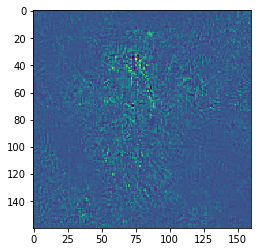

In [0]:
# The saliency maps for the network somewhat resemble the main pixels for the object
# in the validation set image

# Take the maximum value across the channels
val_gradient = tf.reduce_max(val_gradient, axis=3)
val_grad_np = val_gradient.numpy().reshape(resize_shape, resize_shape)
val_grad_np = (val_grad_np - np.min(val_grad_np))/(np.max(val_grad_np) - np.min(val_grad_np))

plt.imshow(val_grad_np)